In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
import numpy as np
import random

import time
import os

Creazione del grafo con l'algoritmo di Barabasi-Albert

In [2]:
N = 50
M = 3
G = nx.barabasi_albert_graph(N, M)

Rappresentazione del grafico

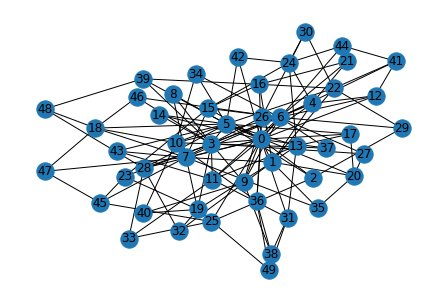

In [3]:
nx.draw(G, with_labels=True)    
plt.show()

Distribuzione della connettività dei nodi

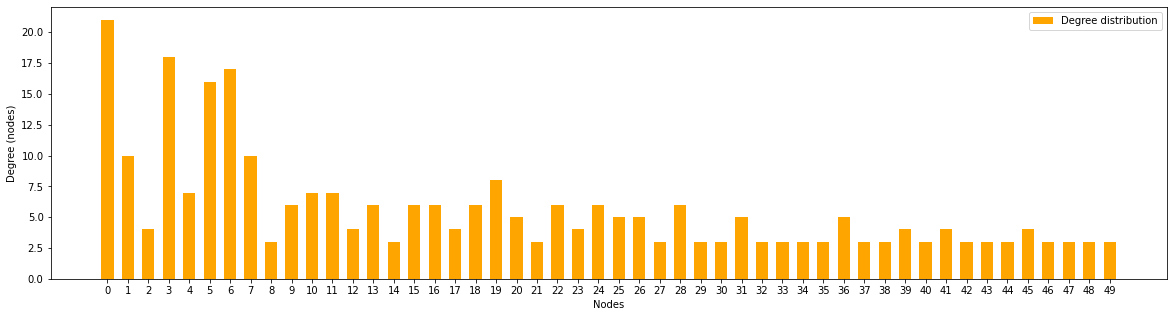

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.4*N, 5))

ax.bar(G.nodes, [d for n,d in G.degree], width=0.6, 
          align='center', color='orange', label='Degree distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Degree (nodes)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

Estrazione della matrice di adiacenza A

In [5]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

Estrazione della matrice di stocastica P e calcolo dei suoi autovalori e autovettori

In [6]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [7]:
matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)
pS = autovettoriP[0]
if pS[0] < 0:
    pS = -pS
#np.dot(np.transpose(matrix),autovettori[0])

In [8]:
autovaloriP

array([ 1.        , -0.69301396, -0.6496384 ,  0.65759723,  0.64121231,
       -0.62021425, -0.58769676, -0.57361723, -0.53875649,  0.57321222,
       -0.5015038 , -0.4814317 , -0.46009485,  0.54155947,  0.51636116,
        0.46395347,  0.46004086,  0.43833936, -0.41722445, -0.37538744,
       -0.35724324, -0.33712462,  0.39922643,  0.37634215, -0.30730151,
       -0.29166723,  0.34375194,  0.32348431, -0.25056368,  0.27502861,
        0.26860384, -0.20843488, -0.19100054, -0.16529668, -0.16205372,
       -0.11784891,  0.23361543,  0.20881725,  0.1979555 ,  0.14260827,
       -0.07504075, -0.05437442,  0.11359874,  0.09325591, -0.02280198,
       -0.00212232,  0.01436704,  0.06368835,  0.05251455,  0.04231941])

Definizione della matrice laplaciana L e calcolo dei suoi autovettori e autovalori

In [9]:
matrixL = np.identity(N) - matrixP

In [10]:
autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)
pS_L = autovettoriL[0]
if pS_L[0] < 0:
    pS_L = -pS_L

In [11]:
autovaloriL

array([-6.67338112e-17,  1.69301396e+00,  1.64963840e+00,  1.62021425e+00,
        3.42402769e-01,  3.58787691e-01,  1.58769676e+00,  1.57361723e+00,
        1.53875649e+00,  1.50150380e+00,  1.48143170e+00,  1.46009485e+00,
        4.26787777e-01,  4.58440532e-01,  4.83638835e-01,  5.36046535e-01,
        5.39959136e-01,  5.61660641e-01,  1.41722445e+00,  1.37538744e+00,
        1.35724324e+00,  1.33712462e+00,  6.00773565e-01,  6.23657846e-01,
        1.30730151e+00,  1.29166723e+00,  6.56248064e-01,  6.76515686e-01,
        1.25056368e+00,  7.24971388e-01,  7.31396156e-01,  1.20843488e+00,
        1.19100054e+00,  1.16529668e+00,  1.16205372e+00,  1.11784891e+00,
        7.66384574e-01,  7.91182751e-01,  8.02044504e-01,  8.57391725e-01,
        1.07504075e+00,  1.05437442e+00,  8.86401263e-01,  9.06744089e-01,
        1.02280198e+00,  1.00212232e+00,  9.85632965e-01,  9.36311646e-01,
        9.47485453e-01,  9.57680590e-01])

La distribuzione stazionaria e il valore di Fiedler estratto dalle due matrici L e P coincidono fino alla 13-esima cifra decimale

In [12]:
i = 13
np.round(pS, i) == np.round(pS_L, i)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [13]:
np.round(1-max(autovaloriP[1:]), i) == np.round(min(autovaloriL[1:]), i)

True

Definizione del valore valore di Fiedler e della distribuzione stazionaria approssimate

In [14]:
FiedlerValue = round(min(autovaloriL[1:]), i)

In [15]:
pS = np.round(pS, i)

Assegnazione degli individui ai nodi per l'evoluzione della dinamica. L'assegnazione degli individui è fatta secondo una distribuzione uniforme.

In [16]:
walker_per_node = 20

In [17]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[new_node] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[n]
    history += [evolution]

In [20]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

# history[0] = [[walker_per_node] * len(G.nodes)]
# history[1] = [[walker_per_node] * len(G.nodes)]
# history[2] = [[walker_per_node] * len(G.nodes)]
time_steps = int(5e3)

In [21]:
t0 = time.time()

for h in range(len(history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution(G, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 3 minutes and 24.229899168014526 seconds


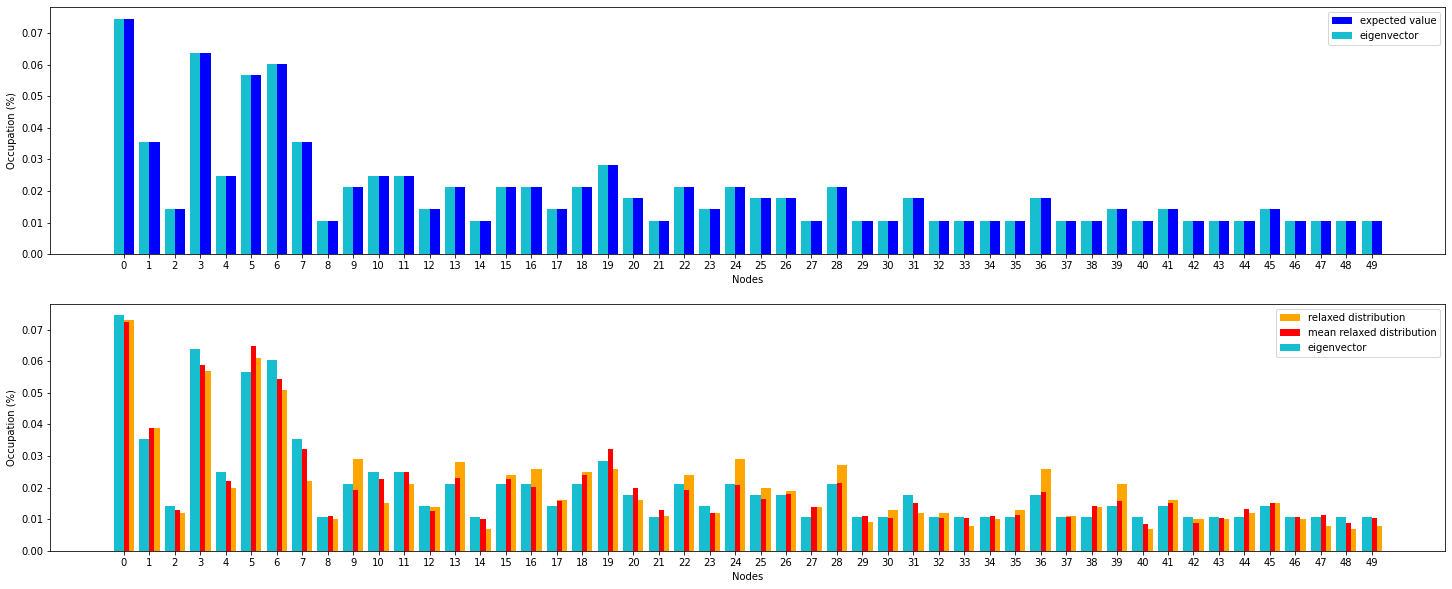

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSNorm = [d for n, d in G.degree()]
pSNorm = [h/sum(pSNorm) for h in pSNorm]

hMean = [[(h1+h2+h3)/(sum(history[0][-1] + history[1][-1] + history[2][-1])) 
         for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] for i in range(len(history[0]))]

ax[0].bar(G.nodes, [h/sum(pSNorm) for h in pSNorm], width=0.4, align='edge', color='blue', label="expected value")
ax[0].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

ax[1].bar(G.nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax[1].bar(G.nodes, hMean[-1], width=0.2, align='edge', color='red', label='mean relaxed distribution')
ax[1].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)


plt.show()

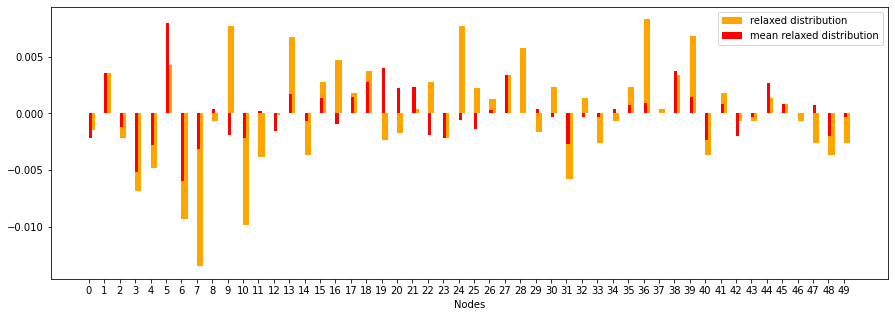

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(G.nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm)], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax.bar(G.nodes, [(h1+h2+h3)/(sum(history[0][-1]) + sum(history[1][-1]) + sum(history[2][-1])) - k
                    for h1, h2, h3, k in zip(history[0][-1], history[1][-1], history[2][-1], pSNorm)],
          width=0.2, align='edge', color='red', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
# ax.set_ylabel("Occupation (%)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

In [ ]:
nodes = [3, 5, 15, 40]
p_node = []

fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(5*len(nodes), 4))

histo = history[0]

for i in range(len(nodes)):
    p_node += [[h[nodes[i]] for h in histo]]
    ax[i].hist(p_node[i], bins = int(walker_per_node*N*max(p_node[i])), density = True)
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_xlabel("Walkers per node")

plt.show()

In [ ]:
for i in range(len(nodes)):
    print("DIstribution for node", nodes[i], ":")
    print(sum(p_node[i])/time_steps)
    print(pSNorm[nodes[i]]*N*walker_per_node)
    print()

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(6*len(nodes), 4))

time_range = hMean
index = np.arange(0, len(time_range), 10)

for i in range(len(nodes)):
    ax[i].plot(index, [time_range[ind][i] for ind in index])
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_ylabel("Walkers per node")
    ax[i].set_xlabel("Time steps")

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,1.5*len(nodes)))

time_range = hMean
index = np.arange(0, len(time_range), 10)

for i in nodes: #list(G.nodes)[0:3]:
    plt.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}")
#     plt.plot(index, [time_range[ind][i] for ind in index])
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

#### Note:

* aggiungere fit su distribuzioni di walkers

* sistema grafica concentrazioni di individui su ogni nodo

* fare grafico per fittare valore di Fiedler